## В этой тетрадке посмотрим, как настроить предобученную библиотеку BERT для классификации текста

Возможно вы слышали о существовании модели BERT. Это нейронная сеть от Google, показавшая отличные результаты на целом ряде задач. С помощью BERT можно создавать программы с ИИ для обработки естественного языка: отвечать на вопросы, заданные в произвольной форме, создавать чат-ботов, автоматические переводчики, анализировать текст и так далее.

**Идея в основе BERT лежит очень простая:** давайте на вход нейросети будем подавать фразы, в которых 15% слов заменим на [MASK], и обучим нейронную сеть предсказывать эти закрытые маской слова.

Например, если подаем на вход нейросети фразу **"Я пришел в [MASK] и купил [MASK]"**, она должна на выходе показать слова **"магазин"** и **"молоко"**. Это упрощенный пример с официальной страницы BERT, на более длинных предложениях разброс возможных вариантов становится меньше, а ответ нейросети однозначнее.

А для того, чтобы нейросеть научилась понимать соотношения между разными предложениями, дополнительно обучим ее предсказывать, является ли вторая фраза логичным продолжением первой. Или это какая-то случайная фраза, не имеющая никакого отношения к первой.

Так, для двух предложений: **"Я пошел в магазин."** и **"И купил там молоко."**, нейросеть должна ответить, что это логично. А если вторая фраза будет **"Карась небо Плутон"**, то должна ответить, что это предложение никак не связано с первым. Ниже мы поиграемся с обоими этими режимами работы BERT.

**Обучив таким образом нейронную сеть на корпусе текстов из Wikipedia и сборнике книг BookCorpus в течении 4 дней на 16 TPU, получили BERT.**

## Задача, которую будем решать с помощью BERT

Мы настроим модель BERT для решения задачи классификации текста. Делать это будем с помощью библиотеки Transformers. 

Установим ее.

In [2]:
#pip install transformers

Looking in indexes: https://pypi.org/simple, http://nexus.mt.ru:8081/repository/pypi-hosted/simple
     |████████████████████████████████| 3.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 9.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda") 
# Если эта операция не достуана - пропустите ее.
# Tсли в процессе выполнения возникаеn ошибка "Torch not compiled with CUDA enabled" - 
# также, выполняйте задание без использования .to(drvice)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Загрузим набор данных.

Если вы работаете в Colab, то сначала вам нужно будет загрузить набор данных о спаме в среду выполнения Colab. Затем прочитайте его как обычно, с использованием pandas.

In [2]:
df = pd.read_csv("C:\SkillFactory\SF_DataScience\Current_tasks\data\spam.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Набор данных состоит из двух столбцов - «label» и «текст». Столбец «текст» содержит текст сообщения, а «label» - это двоичная переменная, где 1 означает спам, а 0 означает, что сообщение не является спамом.

Теперь мы разделим этот набор данных на три набора - обучающий, проверочный и тестовый.

In [3]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                        random_state=42, 
                                                        test_size=0.3, 
                                                        stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                    random_state=42, 
                                                    test_size=0.5, 
                                                    stratify=temp_labels)

## Мы настроим модель, используя train и validation set, и сделаем прогнозы для test.



Теперь импортируем модели BERT и токенизатора BERT
Импортируем базовую модель BERT, которая имеет 110 миллионов параметров. Существует еще более крупная модель BERT, называемая BERT-large, которая имеет 345 миллионов параметров.

In [4]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Пользователь\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Давайте посмотрим, как работает токенизатор BERT. Попробуем закодировать пару предложений с помощью токенизатора.

In [5]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Как видите, на выходе получается словарь из двух элементов.

«Input_ids» содержит целочисленные последовательности входных предложений. Целые числа 101 и 102 - особые токены. Мы добавляем их к обеим последовательностям, а 0 представляет собой маркер заполнения.
«attention_mask» содержит единицы и нули. Она сообщает модели, что нужно обращать внимание на токены, соответствующие значению маски, равному 1, и игнорировать остальные.

## Токинизируем предложения
Поскольку сообщения (текст) в наборе данных имеют разную длину, мы будем использовать заполнение, чтобы все сообщения имели одинаковую длину. Мы можем использовать максимальную длину последовательности для заполнения сообщений. Однако мы также можем посмотреть на распределение длин последовательностей в обучающей выборке, чтобы найти правильную длину заполнения.

<AxesSubplot:>

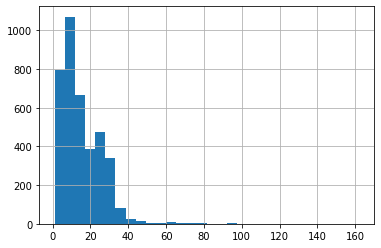

In [6]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

Видно, что большинство сообщений имеют длину 25 слов и меньше. В то время как максимальная длина составляет 175. Итак, если мы выберем 175 в качестве длины заполнения, тогда все входные последовательности будут иметь длину 175, и большинство токенов в этих последовательностях будут токенами заполнения (нулями), которые не помогут модели изучить что-либо полезное и кроме того, это замедлит обучение.

Поэтому мы установим 25 как длину сообщения, и сообщения бОльшим размером будем укорачивать.

In [7]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
train_text.tolist(),
max_length = 25,
pad_to_max_length=True,
truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
val_text.tolist(),
max_length = 25,
pad_to_max_length=True,
truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
test_text.tolist(),
max_length = 25,
pad_to_max_length=True,
truncation=True
)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Итак, теперь мы преобразовали сообщения в train, valid и test наборах в целочисленные последовательности длиной 25 токенов каждая.

Затем мы преобразуем целочисленные последовательности в тензоры. (Тензоры - это альтернатива векторам numpy, но для нейронных сетей, испульзуюся для вычислений в PyTorch.)

In [8]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Теперь мы создадим dataloaders. Dataloaders будут передавать батчи (батч - это группа объектов) train и valid наборов в качестве входных данных для модели на этапе обучения.

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Определим архитектуру модели

Установим параметру requires_grad значение false. Это предотвратит обновление исходных весов предобученной модели во время донастройки. 

In [10]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


Двигаемся дальше, давайте теперь определим нашу архитектуру модели.

In [11]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        
    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        new_bert = self.bert(sent_id, attention_mask=mask)
        _, cls_hs = new_bert[0],new_bert[1]
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [12]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
#model = model.to(device)

Мы будем использовать AdamW в качестве нашего оптимизатора. Это улучшенная версия оптимизатора Adam. Чтобы узнать больше об этом, ознакомьтесь с этой статьей.

In [13]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(),
lr = 1e-5)          # learning rate

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


В нашем наборе данных наблюдается дисбаланс классов. Большинство наблюдений не являются спамом. Итак, мы сначала вычислим веса классов для меток в наборе поездов, а затем передадим эти веса в функцию потерь, чтобы она позаботилась о дисбалансе классов.

In [18]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

Class Weights: [0.57743559 3.72848948]


In [19]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# push to GPU
#weights = weights.to(device)
# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
# number of training epochs
epochs = 10

Точная настройка BERT
Итак, до сих пор мы определили архитектуру модели, мы указали оптимизатор и функцию потерь, и наши загрузчики данных также готовы. Теперь нам нужно определить пару функций для обучения (точной настройки) и оценки модели соответственно.

In [20]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        # push the batch to gpu
        #batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

Мы будем использовать следующую функцию для оценки модели. Он будет использовать данные набора проверки.

In [21]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        #batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

Теперь наконец приступим к настройке модели.

In [22]:
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.675
Validation Loss: 0.655

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.645
Validation Loss: 0.627

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.617
Validation Loss: 0.601

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.590
Validation Loss: 0.574

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.576
Validation Loss: 0.553

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.546
Validation Loss: 0.531

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.526
Validation Loss: 0.512

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.506
Validat

Вы можете видеть, что лосс на валидации все еще уменьшается в конце 10-й эпохи. Это значит, что вы можете попробовать большее количество эпох и достичь наилучшего рещультата. Теперь давайте посмотрим, насколько хорошо модель работает на тестовом наборе данных.


## Сделаем предсказания
Для прогноза загрузим лучшие веса модели, которые были сохранены в процессе обучения.

In [23]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Как только веса загружены, мы можем использовать точно настроенную модель.

In [24]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq, test_mask)#(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

Давайте посмотрим на результаты

In [25]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       724
           1       0.48      0.84      0.61       112

    accuracy                           0.86       836
   macro avg       0.73      0.85      0.76       836
weighted avg       0.91      0.86      0.87       836



И recall, и precision для класса 0 довольно высоки, что означает, что модель довольно хорошо предсказывает этот класс. Однако нашей целью было обнаружение спам-сообщений, поэтому неверная классификация образцов класса 1 (спам) является более серьезной проблемой, чем неправильная классификация образцов класса 0. Если вы посмотрите на recall для класса 1, он равен 0.75, что означает, что модель смогла правильно классифицировать 75% спам-сообщений.

## Итог

Как уже сказано выше, вы можете добиться лучшей точности, обучив модель на большем количестве эпох. Но даже сейчас мы получили неплохой результат для работы с текстом. 

Обязательно попробуйте модель BERT, если перед вами будут стоять задачи по обработке тек